# XGBOOST for time-series forecast

## Import packages

In [312]:
import pandas as pd
import numpy as np
import sqlite3


from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

## Get dataset

In [313]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("../sncf_lostnfound.sqlite")
df = pd.read_sql_query("SELECT * from ObjetTrouve", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

   id          gare                        date  \
0   1  Lille Europe  2016-12-31 17:49:05.000000   
1   2  Lille Europe  2016-12-31 16:09:12.000000   
2   3  Lille Europe  2016-12-31 15:52:03.000000   
3   4  Lille Europe  2016-12-31 13:55:43.000000   
4   5  Lille Europe  2016-12-31 13:41:39.000000   

                                                type  \
0       Porte-monnaie / portefeuille, argent, titres   
1  Appareils électroniques, informatiques, appare...   
2           Pièces d'identités et papiers personnels   
3                Bagagerie: sacs, valises, cartables   
4                Bagagerie: sacs, valises, cartables   

                                     nature  
0                                  Chéquier  
1  Tablette tactile protégée (étui, housse)  
2                              Carte Vitale  
3                 Valise, sac sur roulettes  
4                                Sac à main  


## Pre-processing

In [314]:
df['datetime_obj'] = pd.to_datetime(df['date'])

df['year'] = pd.DatetimeIndex(df['datetime_obj']).year
df['month'] = pd.DatetimeIndex(df['datetime_obj']).month
df['month_name'] = pd.DatetimeIndex(df['datetime_obj']).month_name()
df['day'] = pd.DatetimeIndex(df['datetime_obj']).day
df['day_of_week'] = pd.DatetimeIndex(df['datetime_obj']).day_name()

df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)


df['year_week'] = df['datetime_obj'].dt.strftime('%Y-%U')
df['date_only'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str)

df['date_only'] = pd.to_datetime(df['date_only'])

In [315]:
df.head()

,id,gare,date,type,nature,datetime_obj,year,month,month_name,day,day_of_week,year_month,year_week,date_only
0,1,Lille Europe,2016-12-31 17:49:05.000000,"Porte-monnaie / portefeuille, argent, titres",Chéquier,2016-12-31 17:49:05,2016,12,December,31,Saturday,2016-12,2016-52,2016-12-31
1,2,Lille Europe,2016-12-31 16:09:12.000000,"Appareils électroniques, informatiques, appare...","Tablette tactile protégée (étui, housse)",2016-12-31 16:09:12,2016,12,December,31,Saturday,2016-12,2016-52,2016-12-31
2,3,Lille Europe,2016-12-31 15:52:03.000000,Pièces d'identités et papiers personnels,Carte Vitale,2016-12-31 15:52:03,2016,12,December,31,Saturday,2016-12,2016-52,2016-12-31
3,4,Lille Europe,2016-12-31 13:55:43.000000,"Bagagerie: sacs, valises, cartables","Valise, sac sur roulettes",2016-12-31 13:55:43,2016,12,December,31,Saturday,2016-12,2016-52,2016-12-31
4,5,Lille Europe,2016-12-31 13:41:39.000000,"Bagagerie: sacs, valises, cartables",Sac à main,2016-12-31 13:41:39,2016,12,December,31,Saturday,2016-12,2016-52,2016-12-31


In [316]:
df_month = df.groupby(by = ['year_month'])['year_month'].count().reset_index(name='item_lost').sort_values('year_month')

df_month['year_month'] = pd.to_datetime(df_month['year_month'])
df_month.set_index('year_month', inplace=True,drop=True)

In [317]:
df_month= df_month.sort_index()

In [318]:
df_month.tail()

,item_lost
year_month,
2022-08-01,195
2022-09-01,251
2022-10-01,267
2022-11-01,228
2022-12-01,227


In [319]:
df_day = df.groupby(by = ['date_only'])['date_only'].count().reset_index(name='item_lost').sort_values('date_only')

df_day['date_only'] = pd.to_datetime(df_day['date_only'])
df_day.set_index('date_only', inplace=True,drop=True)

In [320]:
df_day= df_day.sort_index()
df_day.tail()

,item_lost
date_only,
2022-12-27,2
2022-12-28,4
2022-12-29,13
2022-12-30,10
2022-12-31,5


## Exp 1a: Time Series Forecasting - with time series features (Monthly)

### data exploration

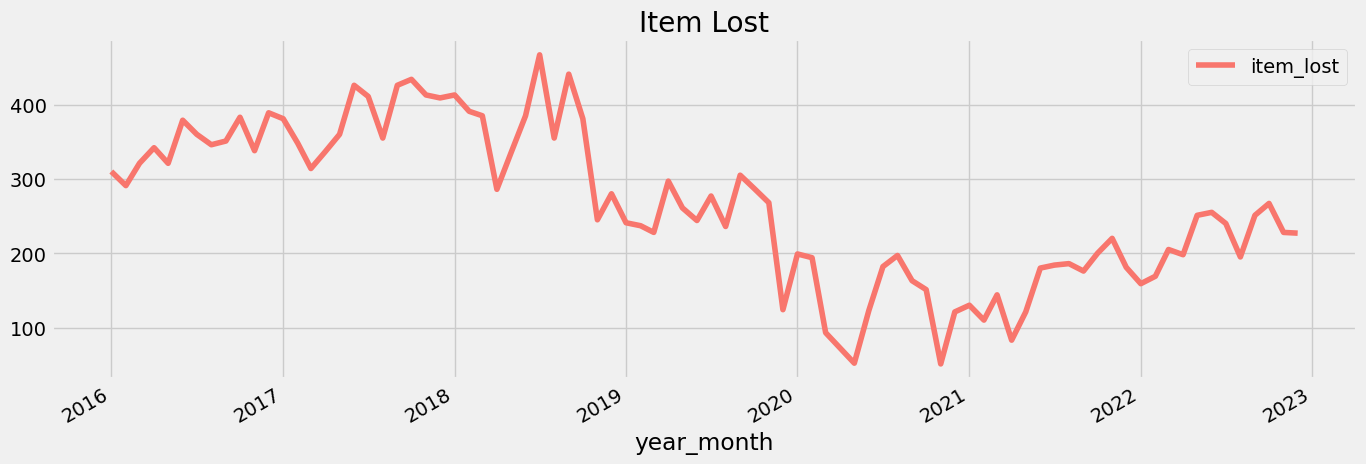

In [321]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_month.plot(figsize=(15,5), color=color_pal[0], title='Item Lost')

### Split data

In [322]:
split_date = '2022-01-01'
df_month_train = df_month.loc[df_month.index < split_date].copy()
df_month_test = df_month.loc[df_month.index >= split_date].copy()

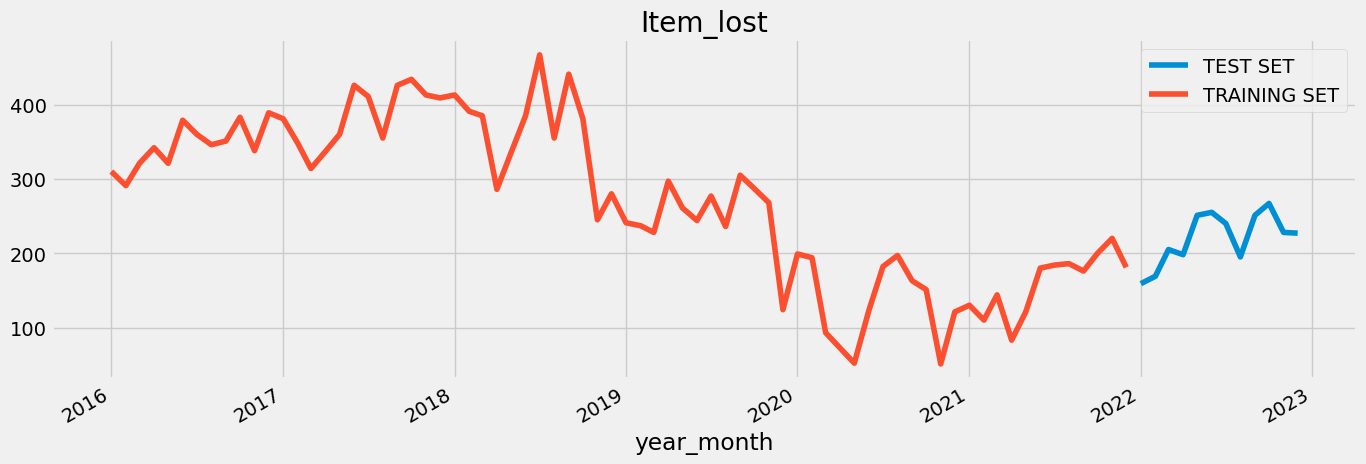

In [323]:
_ = df_month_test \
    .rename(columns={'item_lost': 'TEST SET'}) \
    .join(df_month_train.rename(columns={'item_lost': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Item_lost')

### Create Time Series Features

In [324]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [325]:
X_train, y_train = create_features(df_month_train, label='item_lost')
X_test, y_test = create_features(df_month_test, label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [326]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
year_month,,,,,,,,
2016-01-01,0,4,1,1,2016,1,1,53
2016-02-01,0,0,1,2,2016,32,1,5
2016-03-01,0,1,1,3,2016,61,1,9
2016-04-01,0,4,2,4,2016,92,1,13
2016-05-01,0,6,2,5,2016,122,1,17
...,...,...,...,...,...,...,...,...
2021-08-01,0,6,3,8,2021,213,1,30
2021-09-01,0,2,3,9,2021,244,1,35
2021-10-01,0,4,4,10,2021,274,1,39


### Create XGBoost Model

In [327]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Feature Importances

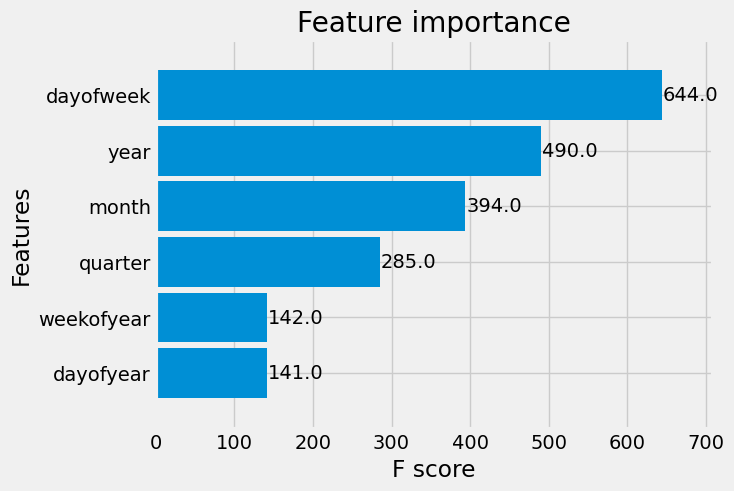

In [328]:
_ = plot_importance(reg, height=0.9)

### Forecast on Test Set

In [329]:
df_month_test['Item_Lost_Prediction'] = reg.predict(X_test)
df_month_all = pd.concat([df_month_test, df_month_train], sort=False)

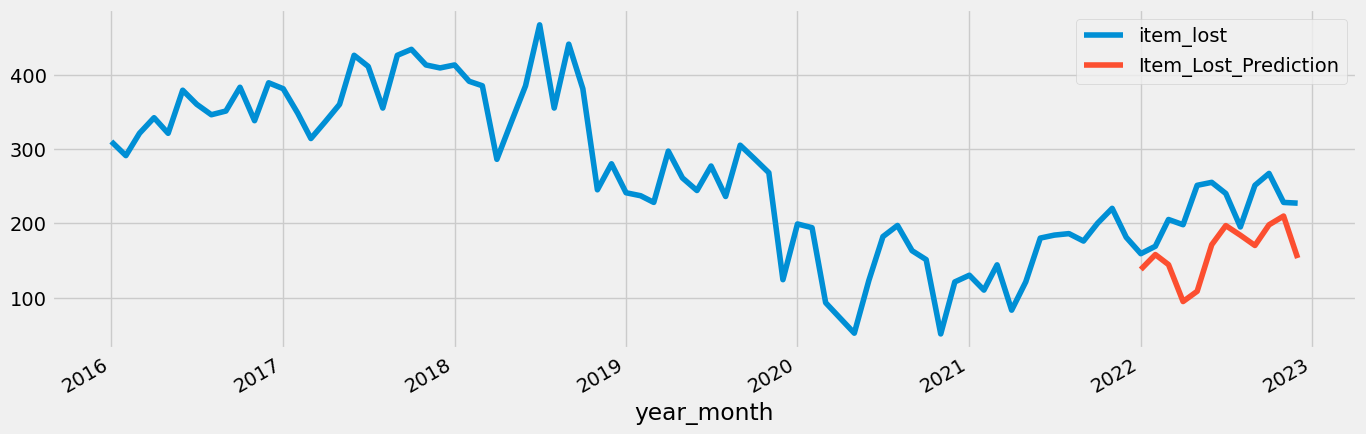

In [330]:
_ = df_month_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

In [331]:
print ("MAE for lay variable = 0 (Month):",mean_absolute_error(df_month_test['item_lost'], df_month_test['Item_Lost_Prediction']))

MAE for lay variable = 0 (Month): 59.991528828938804


## Exp 1b: Time Series Forecasting - with time series features (Monthly)

### Data exploration

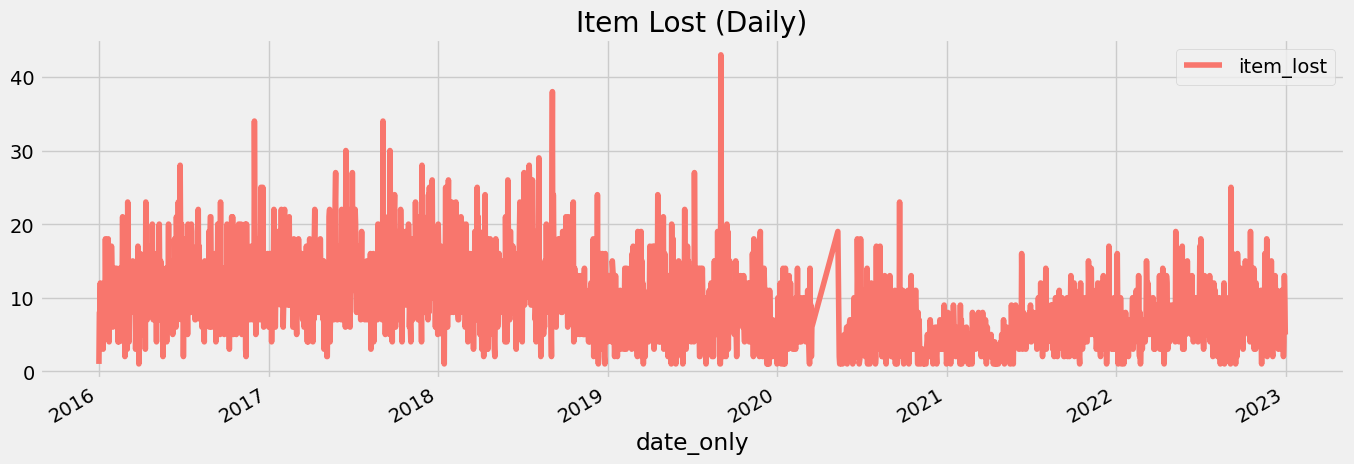

In [332]:
_ = df_day.plot(figsize=(15,5), color=color_pal[0], title='Item Lost (Daily)')

### Train/Test Split

In [333]:
split_date = '2022-01-01'
df_day_train = df_day.loc[df_day.index < split_date].copy()
df_day_test = df_day.loc[df_day.index >= split_date].copy()

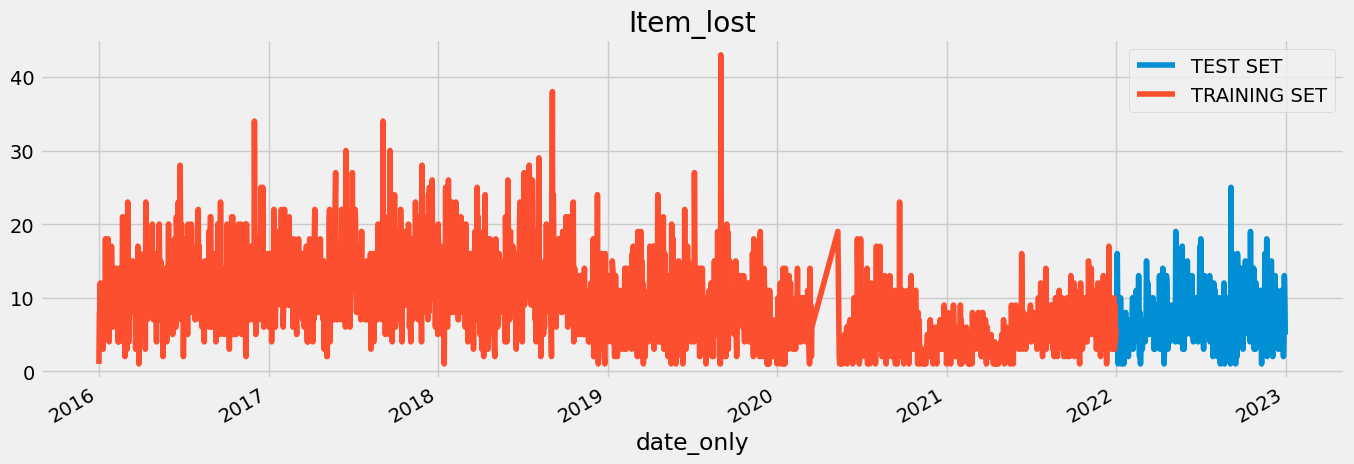

In [334]:
_ = df_day_test \
    .rename(columns={'item_lost': 'TEST SET'}) \
    .join(df_day_train.rename(columns={'item_lost': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Item_lost')

### Create Time Series Features

In [335]:
X_train, y_train = create_features(df_day_train, label='item_lost')
X_test, y_test = create_features(df_day_test, label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Create XGBoost Model

In [336]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Feature Importances

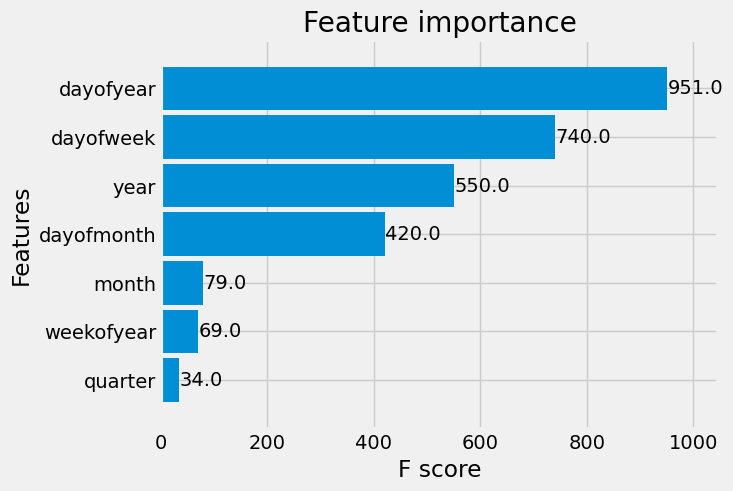

In [337]:
_ = plot_importance(reg, height=0.9)

### Forecast on Test Set

In [338]:
df_day_test['Item_Lost_Prediction'] = reg.predict(X_test)
df_day_all = pd.concat([df_day_test, df_day_train], sort=False)

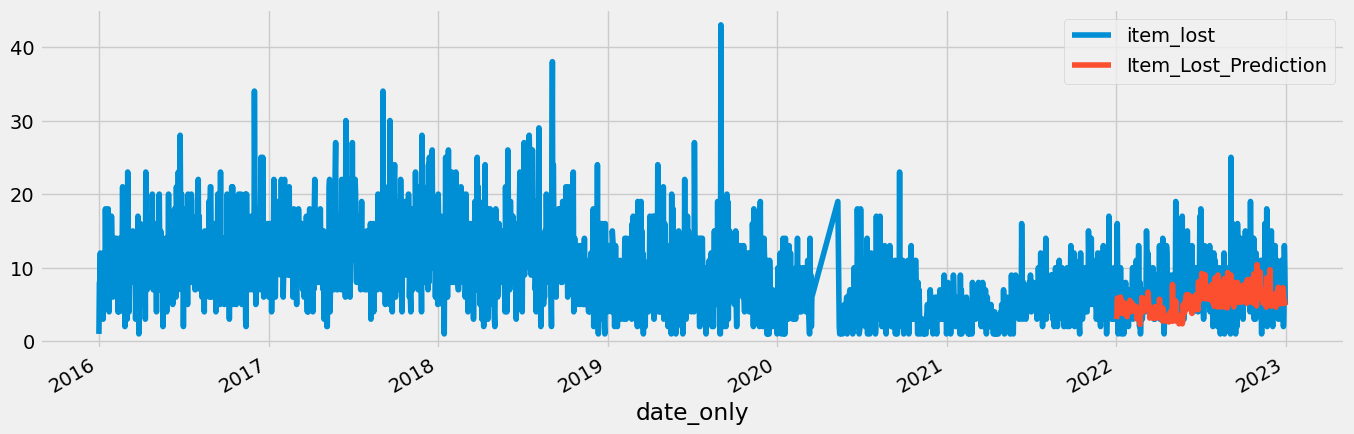

In [339]:
_ = df_day_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

In [340]:
print ("MAE for lay variable = 0 (Day):",mean_absolute_error(df_day_test['item_lost'], df_day_test['Item_Lost_Prediction']))

MAE for lay variable = 0 (Day): 3.0824245430610993


#### Look at first month of predictions

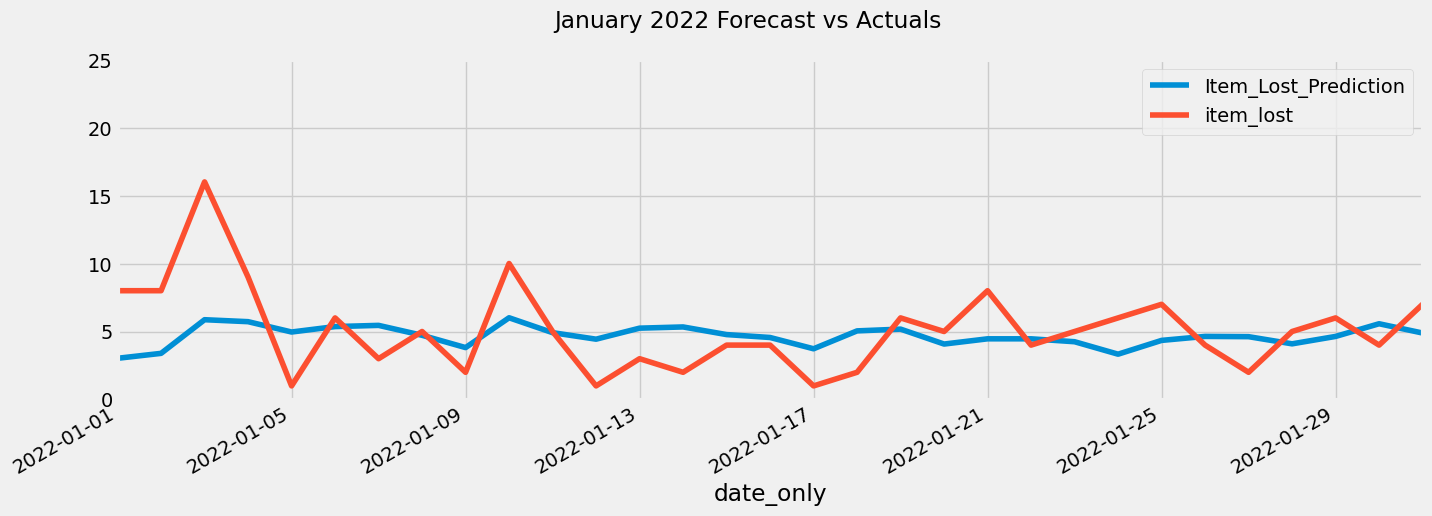

In [341]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_day_all[['Item_Lost_Prediction','item_lost']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='2022-01-01', upper='2022-01-31')
ax.set_ylim(0, 25)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

## Exp 2: Time Series Forecasting as Supervised Learning - one step forecast

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/


### Time Series Data Preparation

In [342]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [343]:
df_month_output = series_to_supervised(df_month)

In [344]:
df_month_output

array([[310., 291.],
       [291., 321.],
       [321., 342.],
       [342., 321.],
       [321., 379.],
       [379., 360.],
       [360., 346.],
       [346., 351.],
       [351., 383.],
       [383., 338.],
       [338., 389.],
       [389., 381.],
       [381., 348.],
       [348., 314.],
       [314., 337.],
       [337., 360.],
       [360., 426.],
       [426., 411.],
       [411., 355.],
       [355., 426.],
       [426., 434.],
       [434., 413.],
       [413., 409.],
       [409., 413.],
       [413., 391.],
       [391., 385.],
       [385., 286.],
       [286., 335.],
       [335., 385.],
       [385., 467.],
       [467., 355.],
       [355., 441.],
       [441., 381.],
       [381., 245.],
       [245., 280.],
       [280., 241.],
       [241., 237.],
       [237., 228.],
       [228., 297.],
       [297., 261.],
       [261., 244.],
       [244., 277.],
       [277., 236.],
       [236., 305.],
       [305., 287.],
       [287., 268.],
       [268., 124.],
       [124.,

#### Walk-forward validation

In [345]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [346]:

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = np.asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [347]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

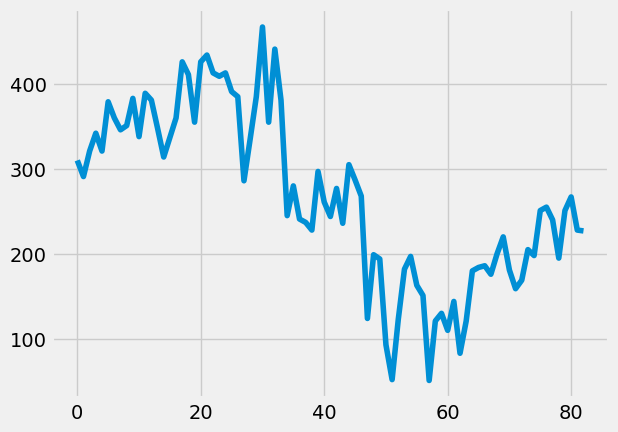

In [348]:
values = df_month.item_lost.to_list()
# plot dataset
plt.plot(values)
plt.show()

In [349]:
values

[310,
 291,
 321,
 342,
 321,
 379,
 360,
 346,
 351,
 383,
 338,
 389,
 381,
 348,
 314,
 337,
 360,
 426,
 411,
 355,
 426,
 434,
 413,
 409,
 413,
 391,
 385,
 286,
 335,
 385,
 467,
 355,
 441,
 381,
 245,
 280,
 241,
 237,
 228,
 297,
 261,
 244,
 277,
 236,
 305,
 287,
 268,
 124,
 199,
 194,
 93,
 52,
 123,
 182,
 197,
 163,
 151,
 51,
 121,
 130,
 110,
 144,
 83,
 121,
 180,
 184,
 186,
 176,
 200,
 220,
 181,
 159,
 169,
 205,
 198,
 251,
 255,
 240,
 195,
 251,
 267,
 228,
 227]

>expected=159.0, predicted=197.0
>expected=169.0, predicted=151.0
>expected=205.0, predicted=151.0
>expected=198.0, predicted=220.0
>expected=251.0, predicted=194.0
>expected=255.0, predicted=280.0
>expected=240.0, predicted=255.0
>expected=195.0, predicted=237.0
>expected=251.0, predicted=93.0
>expected=267.0, predicted=255.0
>expected=228.0, predicted=124.0
>expected=227.0, predicted=297.0
MAE: 51.248


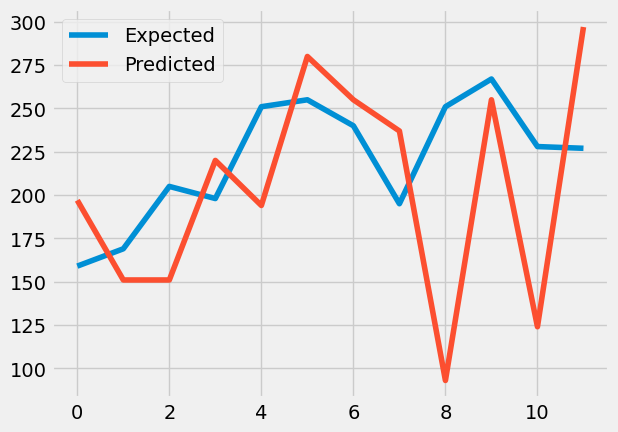

In [350]:
# transform the time series data into supervised learning
data = series_to_supervised(values)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [351]:
data

array([[310., 291.],
       [291., 321.],
       [321., 342.],
       [342., 321.],
       [321., 379.],
       [379., 360.],
       [360., 346.],
       [346., 351.],
       [351., 383.],
       [383., 338.],
       [338., 389.],
       [389., 381.],
       [381., 348.],
       [348., 314.],
       [314., 337.],
       [337., 360.],
       [360., 426.],
       [426., 411.],
       [411., 355.],
       [355., 426.],
       [426., 434.],
       [434., 413.],
       [413., 409.],
       [409., 413.],
       [413., 391.],
       [391., 385.],
       [385., 286.],
       [286., 335.],
       [335., 385.],
       [385., 467.],
       [467., 355.],
       [355., 441.],
       [441., 381.],
       [381., 245.],
       [245., 280.],
       [280., 241.],
       [241., 237.],
       [237., 228.],
       [228., 297.],
       [297., 261.],
       [261., 244.],
       [244., 277.],
       [277., 236.],
       [236., 305.],
       [305., 287.],
       [287., 268.],
       [268., 124.],
       [124.,

## Exp 3a : Times series Forcasting with time series features and lag variables (Monthly)

### Create 1 step lag Feature

In [352]:
n_in = 1 # 1 step lay variable

df_month_shift = df_month.join(df_month.shift(periods=1).rename(columns={'item_lost': 'y-1'})).dropna()

### Split data

In [353]:
split_date = '2022-01-01'
df_month3_train = df_month_shift.loc[df_month_shift.index < split_date].copy()
df_month3_test = df_month_shift.loc[df_month_shift.index >= split_date].copy()

In [354]:
def create_features_3(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','y-1']]
    if label:
        y = df[label]
        return X, y
    return X

In [355]:
X_train3, y_train3 = create_features_3(df_month3_train, label='item_lost')
X_test3, y_test3 = create_features_3(df_month3_test, label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\435877760.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\435877760.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Create XGBoost Model

In [356]:
reg3 = xgb.XGBRegressor(n_estimators=1000)
reg3.fit(X_train3, y_train3,
        eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

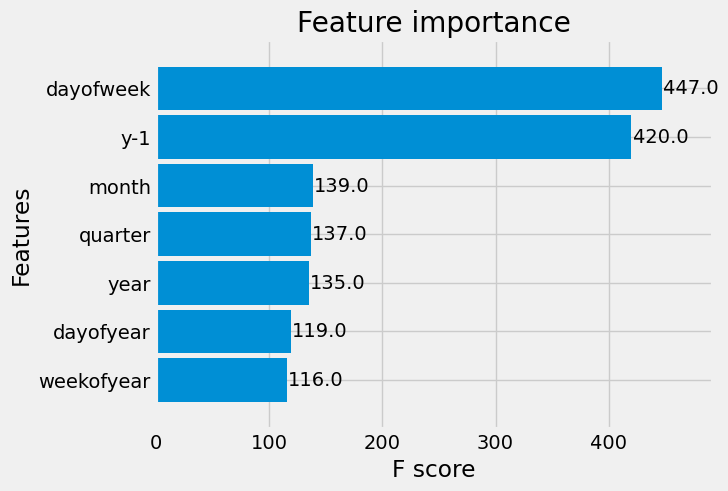

In [357]:
_ = plot_importance(reg3, height=0.9)

### Forecast

In [358]:
df_month3_test['Item_Lost_Prediction'] = reg3.predict(X_test3)
df_month3_all = pd.concat([df_month3_test, df_month3_train], sort=False)

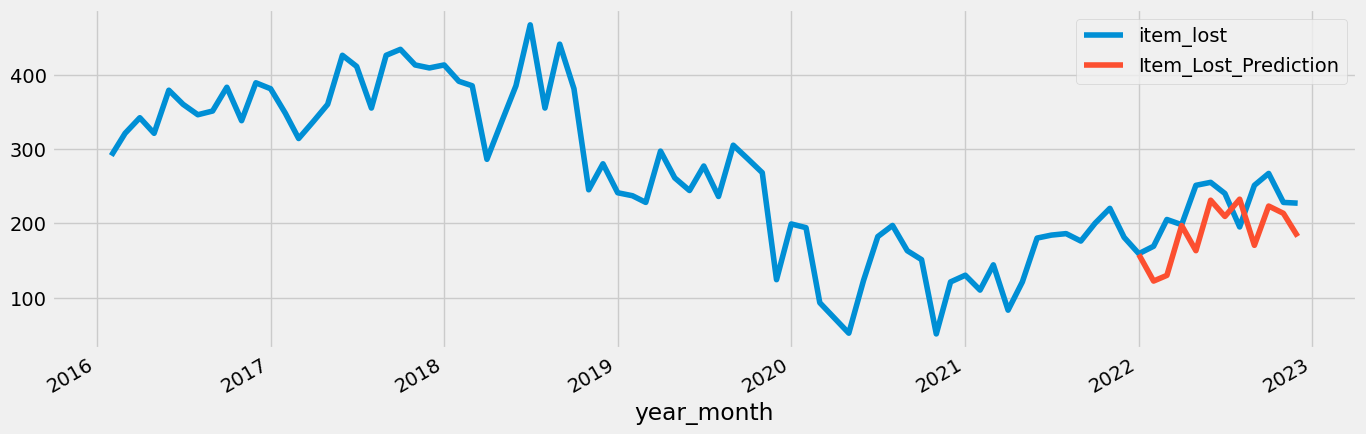

In [359]:
_ = df_month3_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

## Exp 3b : Times series Forcasting with time series features and lag variables (Daily)

### Create 1 step lag Feature

In [360]:
n_in = 1 # 1 step lay variable

df_day_shift = df_day.join(df_day.shift(periods=1).rename(columns={'item_lost': 'y-1'})).dropna()

### Split data

In [361]:
split_date = '2022-01-01'
df_day3_train = df_day_shift.loc[df_day_shift.index < split_date].copy()
df_day3_test = df_day_shift.loc[df_day_shift.index >= split_date].copy()

In [362]:
X_train3b, y_train3b = create_features_3(df_day3_train, label='item_lost')
X_test3b, y_test3b = create_features_3(df_day3_test, label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\435877760.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\435877760.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Create XGBoost Model

In [363]:
reg3b = xgb.XGBRegressor(n_estimators=1000)
reg3b.fit(X_train3b, y_train3b,
        eval_set=[(X_train3b, y_train3b), (X_test3b, y_test3b)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

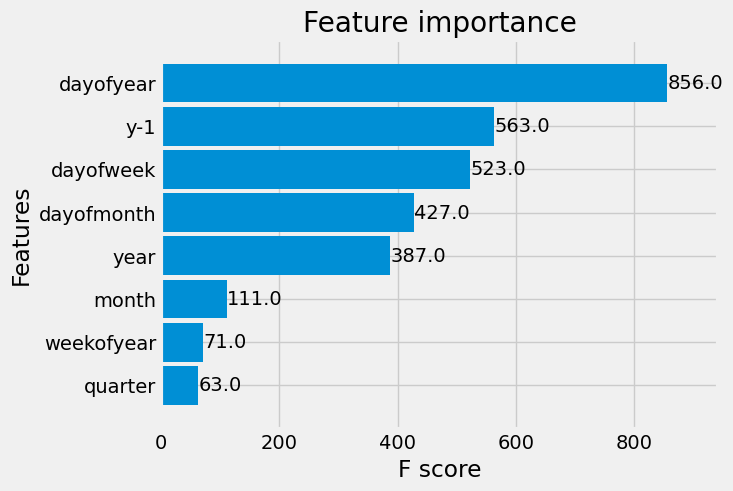

In [364]:
_ = plot_importance(reg3b, height=0.9)

### Forecast

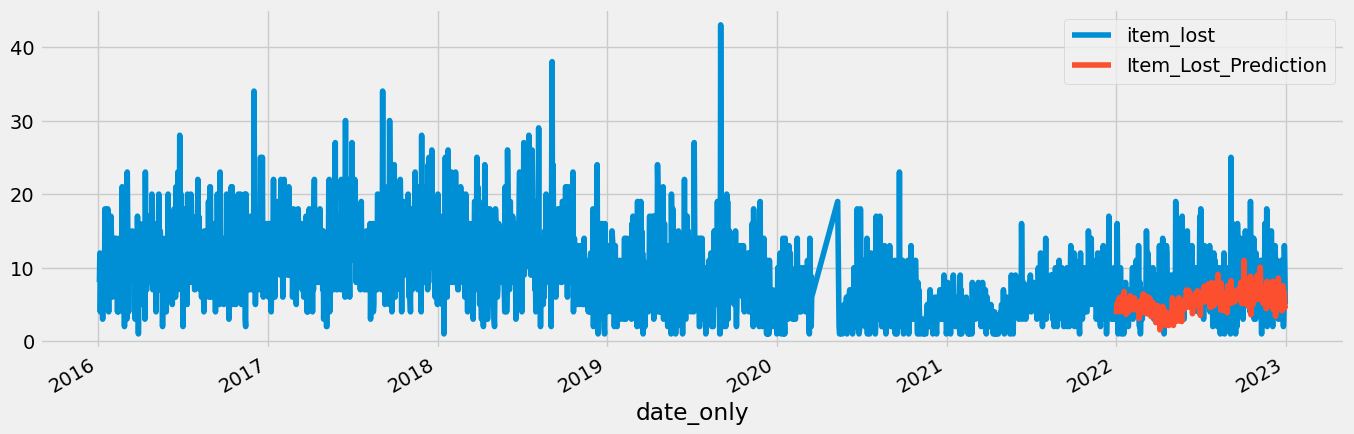

In [365]:
df_day3_test['Item_Lost_Prediction'] = reg3b.predict(X_test3b)
df_day3_all = pd.concat([df_day3_test, df_day3_train], sort=False)

_ = df_day3_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

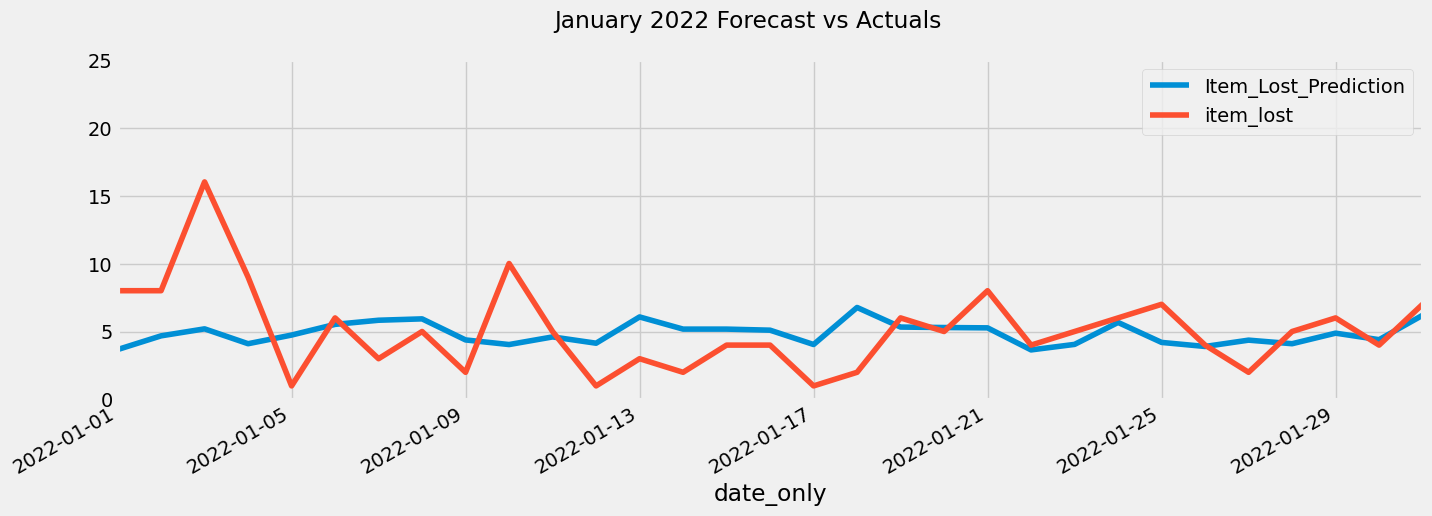

In [366]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_day3_all[['Item_Lost_Prediction','item_lost']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='2022-01-01', upper='2022-01-31')
ax.set_ylim(0, 25)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

In [367]:
print ("MAE for lay variable = 1 (Day):",mean_absolute_error(df_day3_test['item_lost'], df_day3_test['Item_Lost_Prediction']))

MAE for lay variable = 1 (Day): 3.171129596429867


## Exp 4a: TS Forcasting - different lag variable and comparision (monthly)

### Create 1 step lag Feature

In [368]:
n_in = 1 # 1 step lay variable

df_month_shift = df_month.join(df_month.shift(periods=1).rename(columns={'item_lost': 'y-1'})).dropna()
df_month_shift_drop = df_month_shift[['y-1']]
df_month_shift2 = df_month_shift.join(df_month_shift_drop.shift(periods=1).rename(columns={'y-1': 'y-2'})).dropna()
df_month_shift_drop = df_month_shift2[['y-2']]
df_month_shift3 = df_month_shift2.join(df_month_shift_drop.shift(periods=1).rename(columns={'y-2': 'y-3'})).dropna()
df_month_shift_drop = df_month_shift3[['y-3']]
df_month_shift4 = df_month_shift3.join(df_month_shift_drop.shift(periods=1).rename(columns={'y-3': 'y-4'})).dropna()
df_month_shift_drop = df_month_shift4[['y-4']]
df_month_shift5 = df_month_shift4.join(df_month_shift_drop.shift(periods=1).rename(columns={'y-4': 'y-5'})).dropna()



In [433]:
def create_features_tmp (df, label=None):
    """
    Creates time series features from datetime index
    """
    # df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df['year_month'].dt.dayofweek
    df['quarter'] = df['year_month'].dt.quarter
    df['month'] = df['year_month'].dt.month
    df['year'] = df['year_month'].dt.year
    df['dayofyear'] = df['year_month'].dt.dayofyear
    df['dayofmonth'] = df['year_month'].dt.day
    df['weekofyear'] = df['year_month'].dt.weekofyear

    x_label = ['year_month','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear','y-1', 'item_lost']

    # for i in range (1, n_shift+1):
    #     shift_col = 'y-' + str(i)
    #     x_label.append(shift_col)

    # print(df.columns)
    # X = df[[x_label]]
    X = df[x_label]

    if label:
        y = df[label]
        return X, y
    return X

In [428]:
df_month_shift

,year_month,item_lost,y-1,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2016-02-01,291,310.0,1970-01-01 00:00:00.000000000,0,1,2,2016,32,1,5
1,2016-03-01,321,291.0,1970-01-01 00:00:00.000000001,1,1,3,2016,61,1,9
2,2016-04-01,342,321.0,1970-01-01 00:00:00.000000002,4,2,4,2016,92,1,13
3,2016-05-01,321,342.0,1970-01-01 00:00:00.000000003,6,2,5,2016,122,1,17
4,2016-06-01,379,321.0,1970-01-01 00:00:00.000000004,2,2,6,2016,153,1,22
...,...,...,...,...,...,...,...,...,...,...,...
77,2022-08-01,195,240.0,1970-01-01 00:00:00.000000077,0,3,8,2022,213,1,31
78,2022-09-01,251,195.0,1970-01-01 00:00:00.000000078,3,3,9,2022,244,1,35
79,2022-10-01,267,251.0,1970-01-01 00:00:00.000000079,5,4,10,2022,274,1,39
80,2022-11-01,228,267.0,1970-01-01 00:00:00.000000080,1,4,11,2022,305,1,44


In [434]:
df_month_shift_csv = create_features_tmp(df_month_shift)

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\837272236.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['year_month'].dt.weekofyear


In [435]:
df_month_shift_csv

,year_month,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y-1,item_lost
0,2016-02-01,0,1,2,2016,32,1,5,310.0,291
1,2016-03-01,1,1,3,2016,61,1,9,291.0,321
2,2016-04-01,4,2,4,2016,92,1,13,321.0,342
3,2016-05-01,6,2,5,2016,122,1,17,342.0,321
4,2016-06-01,2,2,6,2016,153,1,22,321.0,379
...,...,...,...,...,...,...,...,...,...,...
77,2022-08-01,0,3,8,2022,213,1,31,240.0,195
78,2022-09-01,3,3,9,2022,244,1,35,195.0,251
79,2022-10-01,5,4,10,2022,274,1,39,251.0,267
80,2022-11-01,1,4,11,2022,305,1,44,267.0,228


In [436]:
df_month_shift_csv.to_csv('df_month_shift_csv.csv', index=False)

### Split data

In [369]:
split_date = '2022-01-01'
df_month_shift2_train = df_month_shift2.loc[df_month_shift2.index < split_date].copy()
df_month_shift2_test = df_month_shift2.loc[df_month_shift2.index >= split_date].copy()

df_month_shift3_train = df_month_shift3.loc[df_month_shift3.index < split_date].copy()
df_month_shift3_test = df_month_shift3.loc[df_month_shift3.index >= split_date].copy()

df_month_shift4_train = df_month_shift4.loc[df_month_shift4.index < split_date].copy()
df_month_shift4_test = df_month_shift4.loc[df_month_shift4.index >= split_date].copy()

df_month_shift5_train = df_month_shift5.loc[df_month_shift5.index < split_date].copy()
df_month_shift5_test = df_month_shift5.loc[df_month_shift5.index >= split_date].copy()

In [370]:
def create_features_shift (df, n_shift=1, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    x_label = ['dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear']

    for i in range (1, n_shift+1):
        shift_col = 'y-' + str(i)
        x_label.append(shift_col)

    # print(df.columns)
    # X = df[[x_label]]
    X = df[x_label]

    if label:
        y = df[label]
        return X, y
    return X

In [371]:
df_month_shift2_train

,item_lost,y-1,y-2
year_month,,,
2016-03-01,321,291.0,310.0
2016-04-01,342,321.0,291.0
2016-05-01,321,342.0,321.0
2016-06-01,379,321.0,342.0
2016-07-01,360,379.0,321.0
...,...,...,...
2021-08-01,186,184.0,180.0
2021-09-01,176,186.0,184.0
2021-10-01,200,176.0,186.0


In [372]:
X_train_month_shift_2, y_train_month_shift_2 = create_features_shift(df_month_shift2_train, n_shift=2, label='item_lost')
X_test_month_shift_2, y_test_month_shift_2 = create_features_shift(df_month_shift2_test, n_shift=2, label='item_lost')

X_train_month_shift_3, y_train_month_shift_3 = create_features_shift(df_month_shift3_train, n_shift=3, label='item_lost')
X_test_month_shift_3, y_test_month_shift_3 = create_features_shift(df_month_shift3_test, n_shift=3, label='item_lost')

X_train_month_shift_4, y_train_month_shift_4 = create_features_shift(df_month_shift4_train, n_shift=4, label='item_lost')
X_test_month_shift_4, y_test_month_shift_4 = create_features_shift(df_month_shift4_test, n_shift=4, label='item_lost')

X_train_month_shift_5, y_train_month_shift_5 = create_features_shift(df_month_shift5_train, n_shift=5, label='item_lost')
X_test_month_shift_5, y_test_month_shift_5 = create_features_shift(df_month_shift5_test, n_shift=5, label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\614709445.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\614709445.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\614709445.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\614709445.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Apprenant\AppData\Local

### Create XGBoost Model

In [373]:
reg_shift_2 = xgb.XGBRegressor(n_estimators=1000)
reg_shift_2.fit(X_train_month_shift_2, y_train_month_shift_2,
        eval_set=[(X_train_month_shift_2, y_train_month_shift_2), (X_test_month_shift_2, y_test_month_shift_2)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

reg_shift_3 = xgb.XGBRegressor(n_estimators=1000)
reg_shift_3.fit(X_train_month_shift_3, y_train_month_shift_3,
        eval_set=[(X_train_month_shift_3, y_train_month_shift_3), (X_test_month_shift_3, y_test_month_shift_3)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

reg_shift_4 = xgb.XGBRegressor(n_estimators=1000)
reg_shift_4.fit(X_train_month_shift_4, y_train_month_shift_4,
        eval_set=[(X_train_month_shift_4, y_train_month_shift_4), (X_test_month_shift_4, y_test_month_shift_4)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

reg_shift_5 = xgb.XGBRegressor(n_estimators=1000)
reg_shift_5.fit(X_train_month_shift_5, y_train_month_shift_5,
        eval_set=[(X_train_month_shift_5, y_train_month_shift_5), (X_test_month_shift_5, y_test_month_shift_5)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

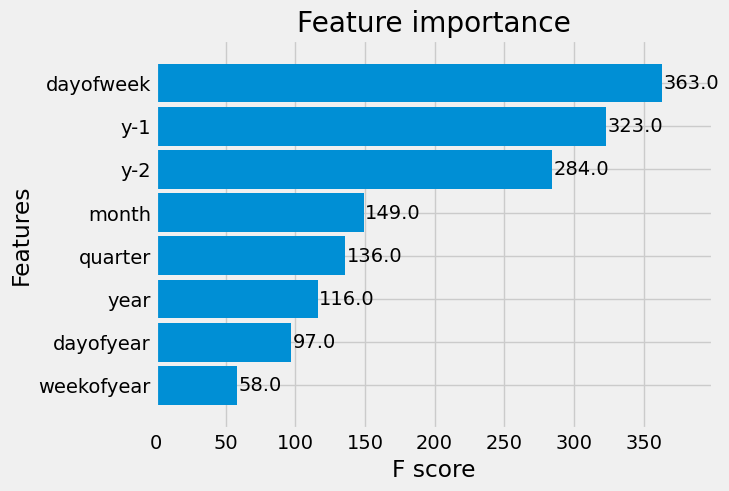

In [374]:
_ = plot_importance(reg_shift_2, height=0.9)

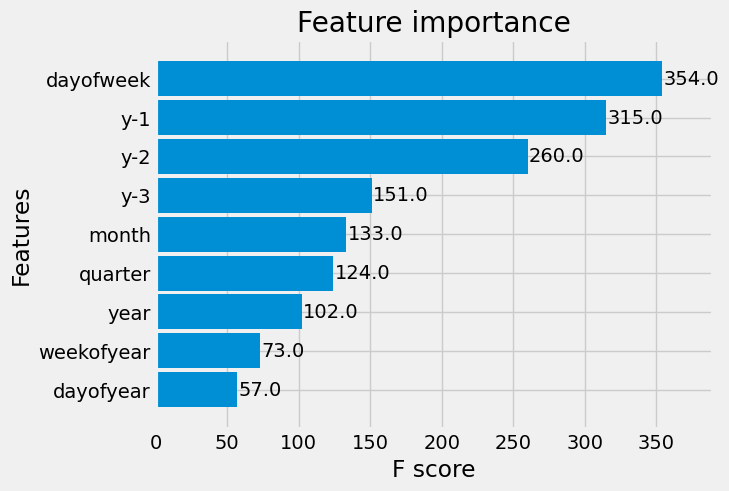

In [375]:
_ = plot_importance(reg_shift_3, height=0.9)

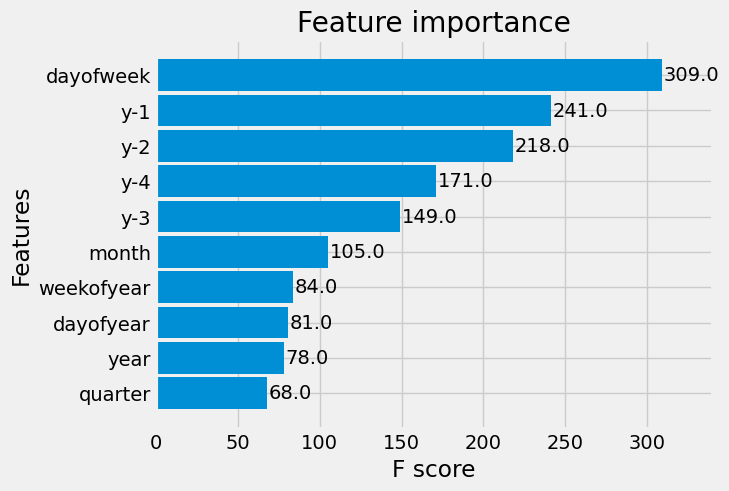

In [376]:
_ = plot_importance(reg_shift_4, height=0.9)

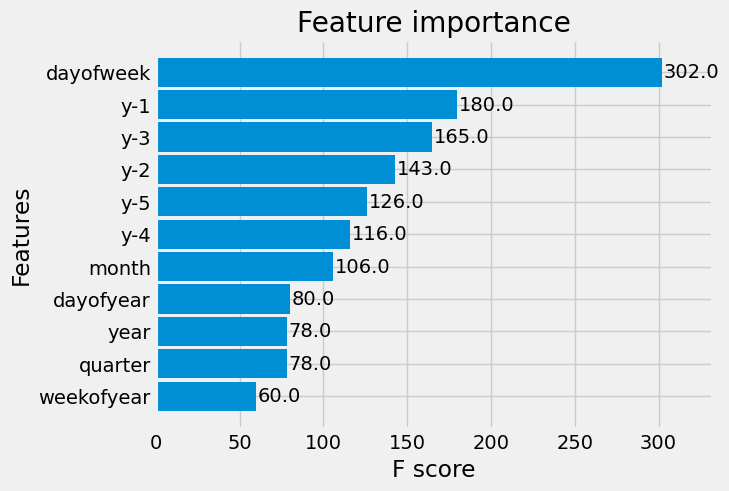

In [377]:
_ = plot_importance(reg_shift_5, height=0.9)

### Forecast

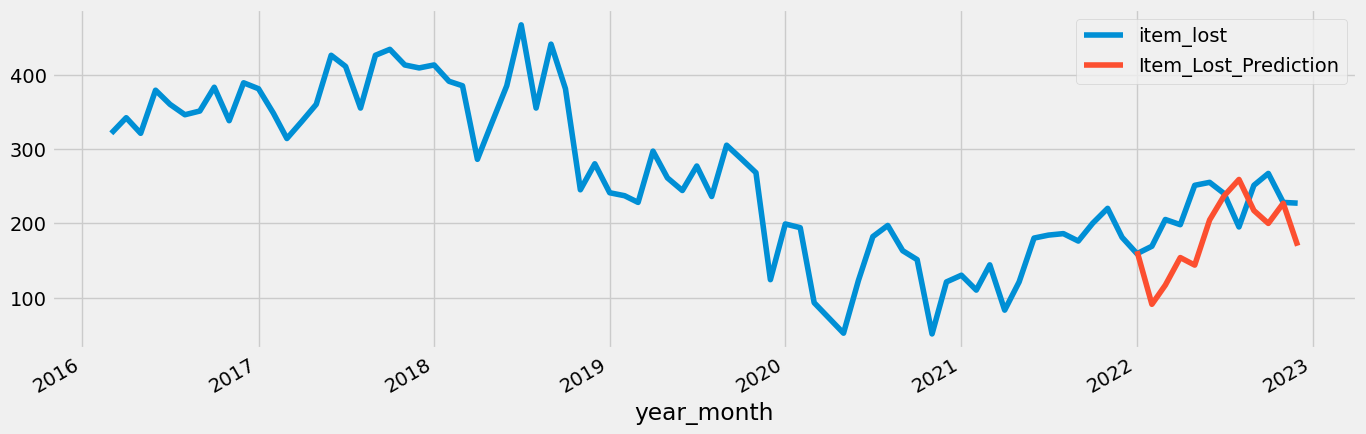

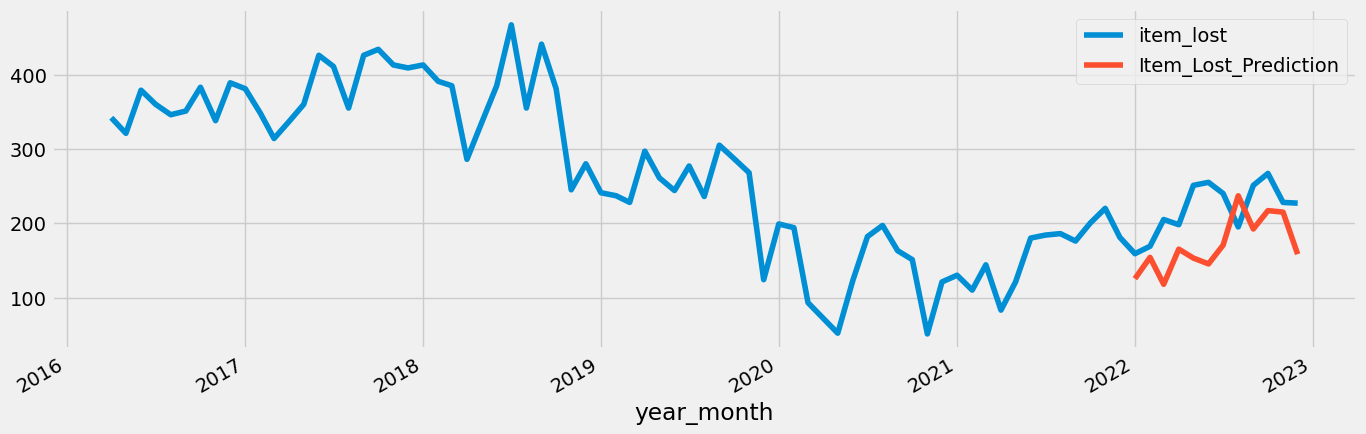

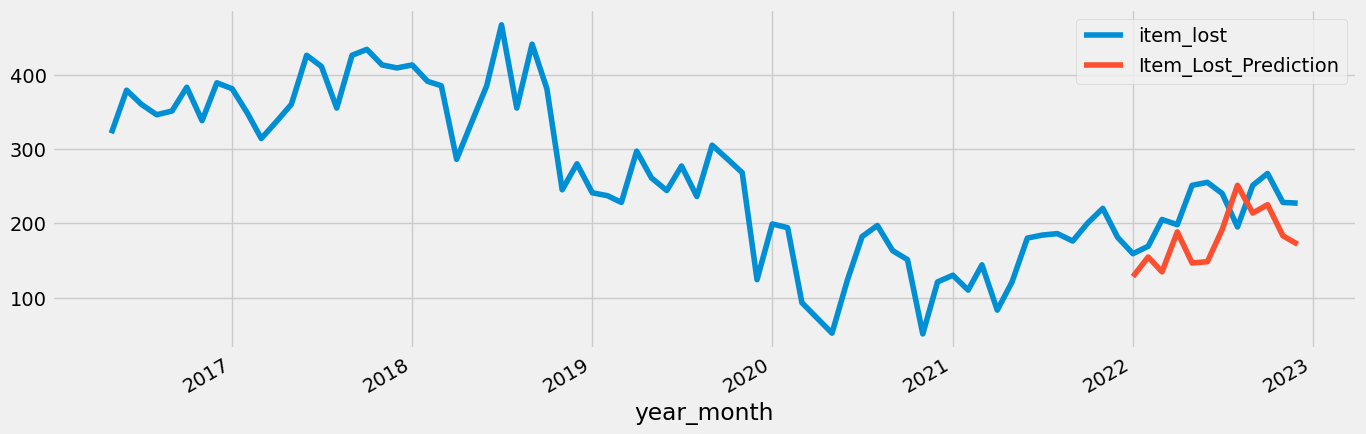

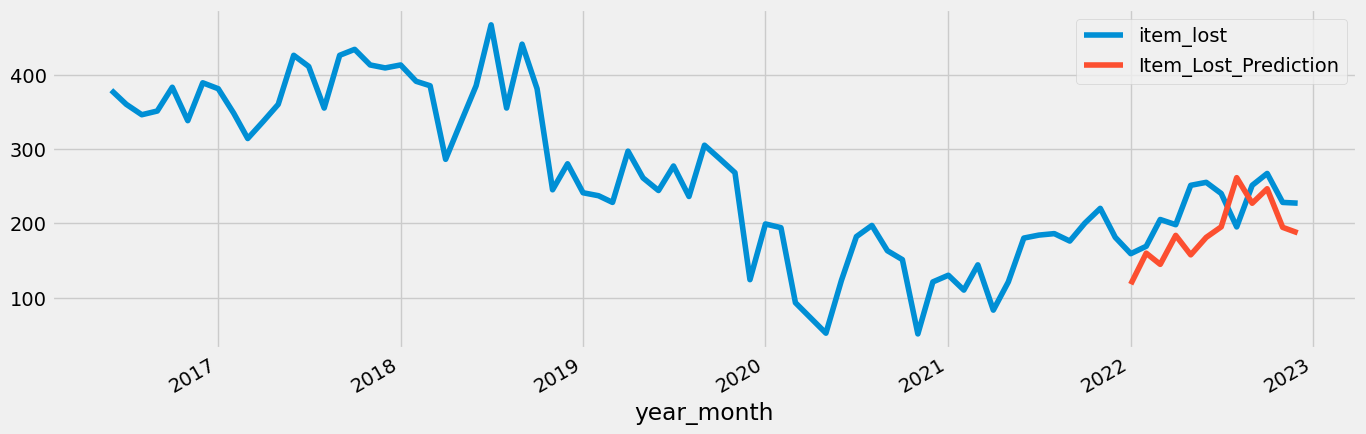

In [378]:
df_month_shift2_test['Item_Lost_Prediction'] = reg_shift_2.predict(X_test_month_shift_2)
df_month_shift2_all = pd.concat([df_month_shift2_test, df_month_shift2_train], sort=False)

_ = df_month_shift2_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))



df_month_shift3_test['Item_Lost_Prediction'] = reg_shift_3.predict(X_test_month_shift_3)
df_month_shift3_all = pd.concat([df_month_shift3_test, df_month_shift3_train], sort=False)

_ = df_month_shift3_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

df_month_shift4_test['Item_Lost_Prediction'] = reg_shift_4.predict(X_test_month_shift_4)
df_month_shift4_all = pd.concat([df_month_shift4_test, df_month_shift4_train], sort=False)

_ = df_month_shift4_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

df_month_shift5_test['Item_Lost_Prediction'] = reg_shift_5.predict(X_test_month_shift_5)
df_month_shift5_all = pd.concat([df_month_shift5_test, df_month_shift5_train], sort=False)

_ = df_month_shift5_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))


In [437]:
print ("MAE for lag variable = 0:",mean_absolute_error(df_month_test['item_lost'], df_month_test['Item_Lost_Prediction']))
print ("MAE for lag variable = 1:",mean_absolute_error(df_month3_test['item_lost'], df_month3_test['Item_Lost_Prediction']))
print ("MAE for lag variable = 2:",mean_absolute_error(df_month_shift2_test['item_lost'], df_month_shift2_test['Item_Lost_Prediction']))
print ("MAE for lag variable = 3:",mean_absolute_error(df_month_shift3_test['item_lost'], df_month_shift3_test['Item_Lost_Prediction']))
print ("MAE for lag variable = 4:",mean_absolute_error(df_month_shift4_test['item_lost'], df_month_shift4_test['Item_Lost_Prediction']))
print ("MAE for lag variable = 5:",mean_absolute_error(df_month_shift5_test['item_lost'], df_month_shift5_test['Item_Lost_Prediction']))

MAE for lag variable = 0: 59.991528828938804
MAE for lag variable = 1: 40.71292495727539
MAE for lag variable = 2: 49.89749336242676
MAE for lag variable = 3: 56.53135553995768
MAE for lag variable = 4: 51.745601654052734
MAE for lag variable = 5: 43.52335993448893


# Test with the built in train test split

In [380]:
df_month_shift_new = df_month_shift
df_month_shift_new.reset_index(inplace=True)
df_month_shift_new.head()

,year_month,item_lost,y-1
0,2016-02-01,291,310.0
1,2016-03-01,321,291.0
2,2016-04-01,342,321.0
3,2016-05-01,321,342.0
4,2016-06-01,379,321.0


In [381]:
df_month_shift_new

,year_month,item_lost,y-1
0,2016-02-01,291,310.0
1,2016-03-01,321,291.0
2,2016-04-01,342,321.0
3,2016-05-01,321,342.0
4,2016-06-01,379,321.0
...,...,...,...
77,2022-08-01,195,240.0
78,2022-09-01,251,195.0
79,2022-10-01,267,251.0
80,2022-11-01,228,267.0


In [401]:
X_data, y_data = create_features_3(df_month_shift_new.set_index('year_month'), label='item_lost')

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\435877760.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [402]:
X_data = X_data.drop(columns='hour')

In [404]:
# First, let's split the time series into training and testing sets using TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

X = X_data
y = y_data

tscv = TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(X)):

    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    # X_train = X.iloc[train_index].copy

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Next, let's import and initialize the XGBoost model
import xgboost as xgb

model = xgb.XGBRegressor()

# Now, let's fit the model to the training data
model.fit(X_train, y_train)

# And finally, let's make predictions on the test set and evaluate the model
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, y_pred))

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
  Test:  index=[17 18 19 20 21 22 23 24 25 26 27 28 29]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
  Test:  index=[30 31 32 33 34 35 36 37 38 39 40 41 42]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
  Test:  index=[43 44 45 46 47 48 49 50 51 52 53 54 55]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
  Test:  index=[56 57 58 59 60 61 62 63 64 65 66 67 68]
Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]


c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [410]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [405]:
y_pred

array([154.7828 , 149.91579, 111.618  , 124.17761, 176.0979 , 146.23398,
       217.4526 , 209.23953, 215.08543, 165.44162, 219.45049, 206.66418,
       148.68083], dtype=float32)

In [407]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y-1
year_month,,,,,,,,
2021-12-01,2,4,12,2021,335,1,48,220.0
2022-01-01,5,1,1,2022,1,1,52,181.0
2022-02-01,1,1,2,2022,32,1,5,159.0
2022-03-01,1,1,3,2022,60,1,9,169.0
2022-04-01,4,2,4,2022,91,1,13,205.0
2022-05-01,6,2,5,2022,121,1,17,198.0
2022-06-01,2,2,6,2022,152,1,22,251.0
2022-07-01,4,3,7,2022,182,1,26,255.0
2022-08-01,0,3,8,2022,213,1,31,240.0


In [406]:
y_test

year_month
2021-12-01    181
2022-01-01    159
2022-02-01    169
2022-03-01    205
2022-04-01    198
2022-05-01    251
2022-06-01    255
2022-07-01    240
2022-08-01    195
2022-09-01    251
2022-10-01    267
2022-11-01    228
2022-12-01    227
Name: item_lost, dtype: int64

In [408]:
X_test['Actual'] = y_test


C:\Users\Apprenant\AppData\Local\Temp\ipykernel_5768\3299568593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Actual'] = y_test


In [409]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y-1,Actual
year_month,,,,,,,,,
2021-12-01,2,4,12,2021,335,1,48,220.0,181
2022-01-01,5,1,1,2022,1,1,52,181.0,159
2022-02-01,1,1,2,2022,32,1,5,159.0,169
2022-03-01,1,1,3,2022,60,1,9,169.0,205
2022-04-01,4,2,4,2022,91,1,13,205.0,198
2022-05-01,6,2,5,2022,121,1,17,198.0,251
2022-06-01,2,2,6,2022,152,1,22,251.0,255
2022-07-01,4,3,7,2022,182,1,26,255.0,240
2022-08-01,0,3,8,2022,213,1,31,240.0,195


In [ ]:
df_month_shift2_all = pd.concat([df_month_shift2_test, df_month_shift2_train], sort=False)

_ = df_month_shift2_all[['item_lost','Item_Lost_Prediction']].plot(figsize=(15, 5))

In [296]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y-1
0,0,1,2,2016,32,1,5,310.0
1,1,1,3,2016,61,1,9,291.0
2,4,2,4,2016,92,1,13,321.0
3,6,2,5,2016,122,1,17,342.0
4,2,2,6,2016,153,1,22,321.0
...,...,...,...,...,...,...,...,...
64,3,3,7,2021,182,1,26,180.0
65,6,3,8,2021,213,1,30,184.0
66,2,3,9,2021,244,1,35,186.0
67,4,4,10,2021,274,1,39,176.0
